In [1]:
import pandas as pd

DATA_PATH = "./donnees/ecommerce/"

In [2]:
# Load
orders    = pd.read_parquet(DATA_PATH + "orders.parquet")
reviews   = pd.read_parquet(DATA_PATH + "reviews.parquet")
payments  = pd.read_parquet(DATA_PATH + "payments.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")
geo       = pd.read_parquet(DATA_PATH + "geolocation.parquet")

# --- Geo / colonnes variables ---
zip_col   = "geolocation_zip_code_prefix" if "geolocation_zip_code_prefix" in geo.columns else "zip_code"
lat_col   = "geolocation_lat" if "geolocation_lat" in geo.columns else "lat"
lng_col   = "geolocation_lng" if "geolocation_lng" in geo.columns else "lng"
city_col  = "geolocation_city" if "geolocation_city" in geo.columns else "city"
state_col = "geolocation_state" if "geolocation_state" in geo.columns else "state"

geo_cust = (
    geo[[zip_col, lat_col, lng_col, city_col, state_col]]
    .dropna(subset=[zip_col])
    .astype({zip_col: "string"})
    .groupby(zip_col, as_index=False)
    .agg({lat_col: "mean", lng_col: "mean", city_col: "first", state_col: "first"})
    .rename(columns={
        zip_col: "customer_zip_code_prefix",
        lat_col: "cust_lat", lng_col: "cust_lng",
        city_col: "cust_geo_city", state_col: "cust_geo_state"
    })
)

# --- Customers (id, zip, ville/état) ---
cust_cols = [c for c in ["customer_id", "customer_zip_code_prefix", "customer_city", "customer_state"] if c in customers]
customers_slim = customers[cust_cols].copy()
if "customer_zip_code_prefix" in customers_slim:
    customers_slim["customer_zip_code_prefix"] = customers_slim["customer_zip_code_prefix"].astype("string")

# --- Orders (id, status, timestamp) ---
ts_col = "order_purchase_timestamp" if "order_purchase_timestamp" in orders.columns else (
    "purchase_timestamp" if "purchase_timestamp" in orders.columns else None
)
orders_keep = ["order_id"]
for c in ["order_status", ts_col, "customer_id"]:
    if c in orders.columns:
        orders_keep.append(c)
orders_slim = orders[orders_keep].copy()

# --- Payments (agrégés au grain commande) ---
agg_dict = {"payment_value": ("payment_value", "sum")}
if "payment_sequential" in payments.columns:
    agg_dict["payment_methods_count"] = ("payment_sequential", "max")
if "payment_installments" in payments.columns:
    agg_dict["payment_installments_max"] = ("payment_installments", "max")
if "payment_type" in payments.columns:
    agg_dict["payment_main_type"] = ("payment_type", lambda s: s.mode().iloc[0] if not s.mode().empty else None)
    agg_dict["payment_types_concat"] = ("payment_type", lambda s: ",".join(sorted(set(map(str, s.dropna())))))

pay = (
    payments.groupby("order_id", as_index=False)
    .agg(**agg_dict)
    .rename(columns={"payment_value": "order_payment_value"})
)

# --- Reviews (score par commande) ---
rev_keep = [c for c in ["review_id","order_id","review_score","review_creation_date","review_answer_timestamp"] if c in reviews]
reviews_slim = reviews[rev_keep].copy()

# --- Consolidation (LEFT JOINs) ---
df1 = (
    orders_slim
    .merge(pay, on="order_id", how="left")
    .merge(reviews_slim, on="order_id", how="left")
    .merge(customers_slim, on="customer_id", how="left")
    .merge(geo_cust, on="customer_zip_code_prefix", how="left")
)

# --- Temps ---
if ts_col:
    df1[ts_col] = pd.to_datetime(df1[ts_col], errors="coerce")
    df1["year"]  = df1[ts_col].dt.year
    df1["month"] = df1[ts_col].dt.month

# --- Colonnes finales ---
cols_df1 = [c for c in [
    "order_id","customer_id",
    "review_id","review_score","review_creation_date","review_answer_timestamp",
    "order_payment_value","payment_methods_count","payment_installments_max",
    "payment_main_type","payment_types_concat",
    "order_status",
    "customer_zip_code_prefix","customer_city","customer_state",
    "cust_lat","cust_lng","cust_geo_city","cust_geo_state",
    ts_col,"year","month"
] if c in df1.columns]

df_sales = df1[cols_df1].copy()

print("df_sales shape:", df_sales.shape)
display(df_sales.head(5))
display(df_sales.describe(include="all").T)


KeyError: "Column(s) ['payment_value'] do not exist"

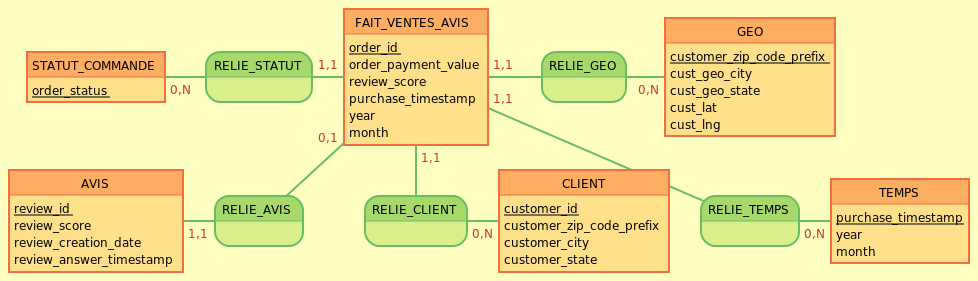

In [2]:
# Le modèle a été généré sur Mocodo puis exporté en PNG.
from IPython.display import Image, display

display(Image(filename="etoile_analyse_vente.png"))
